In [24]:
from os import listdir
import random
from xmlrpc.client import boolean
from numpy.core.records import array
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn
import torch
from torch.nn.modules import loss
import eikon as ek
import math
from threading import Event
from datetime import datetime, date
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt

def getDataFromCSV(path):
    data = pd.read_csv(path, index_col="Date", parse_dates=True)
    return data

df = getDataFromCSV(r"C:\Users\jensb\Documents\Praktikum\Stock_Prediction\03-07-2021\JugendForscht\CSVs\AMZN_hourly.csv")

df = df.drop(columns=["Unnamed: 0", "index"])

X = df.iloc[:-1, :]
y = pd.DataFrame(df["CLOSE"][1:])
mm = MinMaxScaler(feature_range=(0,1))
ss = StandardScaler()

X_ss = ss.fit_transform(X)
y_mm =mm.fit_transform(y)

X_batches = []
y_batches = []
for i in range(5, len(X_ss)):
    X_batches.append(X_ss[i-5:i])
    y_batches.append(y_mm[i-1, :])

X_batches = np.array(X_batches)
y_batches = np.array(y_batches)

X_train = X_batches[:3800, :]
X_test = X_batches[3800:, :]

y_train = y_batches[:3800, :]
y_test = y_batches[3800:, :]

#print("Training Shape: ", X_train.shape, y_train.shape)
#print("Testing Shape: ", X_test.shape, y_test.shape) 

X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test)) 

print("Training Tensor Shape: ", X_train_tensors.shape, y_train_tensors.shape)
print("Testing Tensor Shape: ", X_test_tensors.shape, y_test_tensors.shape) 

X_train_tensors_final = torch.reshape(X_train_tensors, (X_train_tensors.shape[0], 1,X_train_tensors.shape[1], X_train_tensors.shape[2]))
X_test_tensors_final = torch.reshape(X_test_tensors, (X_test_tensors.shape[0], 1,X_test_tensors.shape[1], X_test_tensors.shape[2]))

class Netz(nn.Module):
    def __init__(self, outputs, inputs, hiddens, layers, seq_length):
        super(Netz, self).__init__()
        self.outputs = outputs
        self.inputs = inputs
        self.hiddens = hiddens
        self.layers = layers
        self.seq_length = seq_length

        self.lstm1 = nn.LSTM(input_size=inputs, hidden_size=hiddens, num_layers=layers, batch_first=True)
        self.fc1 = nn.Linear(hiddens, 128)
        self.fc2 = nn.Linear(128, outputs)
        self.relu = nn.ReLU()
        

    def forward(self, x):
        h_0 = self.initHiddenInternal(x)
        c_0 = self.initHiddenInternal(x)
        output, (hn, cn) = self.lstm1(x, (h_0, c_0))
        hn = hn.view(-1, self.hiddens)
        out = self.relu(hn)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out
    
    def initHiddenInternal(self, x):
        return Variable(torch.zeros(self.layers, x.size(0), self.hiddens))

num_epochs = 120
learning_rate = 0.0005

inputs = 5
hiddens = 60
layers = 1
outputs = 1

model = Netz(outputs, inputs, hiddens, layers, X_train_tensors.shape[0])

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

lossData = []
def train(epoch):
    model.train()
    optimizer.zero_grad()
    output = model.forward(X_train_tensors)
    loss = criterion(output, y_train_tensors)
    loss.backward()
    optimizer.step()
    lossData.append(loss.item())
    print("Epoch: %d, loss: %1.5f" % (epoch + 1, loss.item()))

for i in range(num_epochs):
    train(i)

Training Tensor Shape:  torch.Size([3800, 5, 5]) torch.Size([3800, 1])
Testing Tensor Shape:  torch.Size([196, 5, 5]) torch.Size([196, 1])
Epoch: 1, loss: 0.32609
Epoch: 2, loss: 0.31778
Epoch: 3, loss: 0.30954
Epoch: 4, loss: 0.30134
Epoch: 5, loss: 0.29321
Epoch: 6, loss: 0.28513
Epoch: 7, loss: 0.27710
Epoch: 8, loss: 0.26912
Epoch: 9, loss: 0.26119
Epoch: 10, loss: 0.25331
Epoch: 11, loss: 0.24545
Epoch: 12, loss: 0.23761
Epoch: 13, loss: 0.22976
Epoch: 14, loss: 0.22192
Epoch: 15, loss: 0.21407
Epoch: 16, loss: 0.20620
Epoch: 17, loss: 0.19832
Epoch: 18, loss: 0.19041
Epoch: 19, loss: 0.18247
Epoch: 20, loss: 0.17451
Epoch: 21, loss: 0.16652
Epoch: 22, loss: 0.15852
Epoch: 23, loss: 0.15049
Epoch: 24, loss: 0.14243
Epoch: 25, loss: 0.13435
Epoch: 26, loss: 0.12624
Epoch: 27, loss: 0.11811
Epoch: 28, loss: 0.10997
Epoch: 29, loss: 0.10182
Epoch: 30, loss: 0.09369
Epoch: 31, loss: 0.08560
Epoch: 32, loss: 0.07759
Epoch: 33, loss: 0.06969
Epoch: 34, loss: 0.06195
Epoch: 35, loss: 0.0

Loss:  0.0007852372946217656


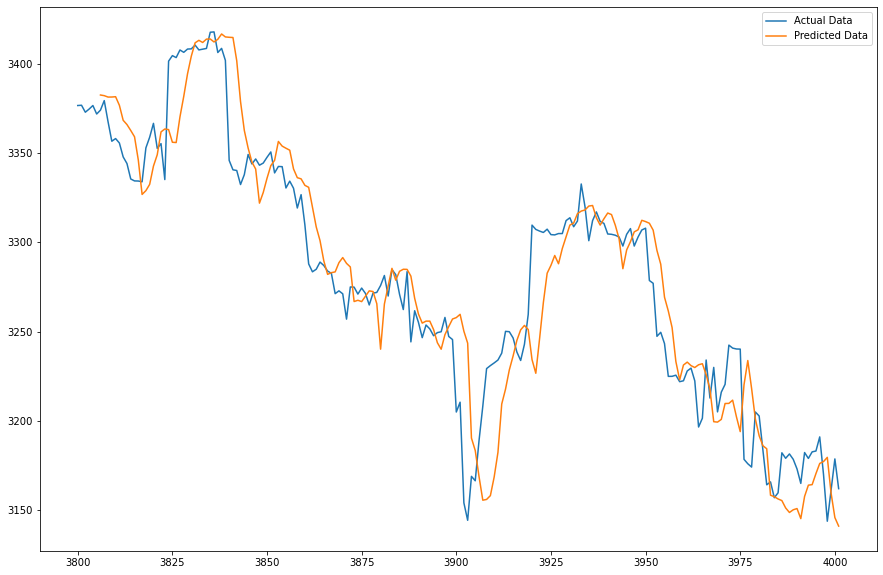

In [25]:
def test():
    #Test our Model with Test Data
    optimizer.zero_grad()
    train_predict = model(X_test_tensors)
    loss = criterion(train_predict, y_test_tensors)
    print("Loss: ", loss.item())
    train_predict = mm.inverse_transform(train_predict.data.numpy()).flatten().tolist()
    a = [np.nan] * (len(df) - len(train_predict))
    train_predict = a + train_predict
    df["Predicted Testing Data"] = train_predict

    plt.figure(figsize=(15,10))
    plt.plot(df["CLOSE"][3800:], label="Actual Data")
    plt.plot(df["Predicted Testing Data"][3800:], label="Predicted Data")
    plt.legend()
    plt.show()
df = df.reset_index()
test()

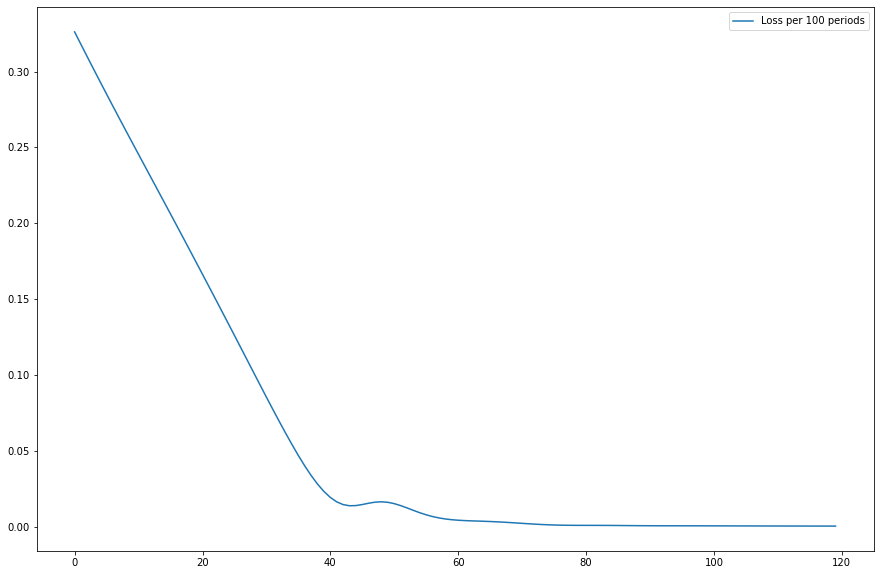

In [26]:
def plotLoss():
    plt.figure(figsize=(15, 10))
    plt.plot(lossData, label="Loss per 100 periods")
    plt.legend()
    plt.show()

plotLoss()

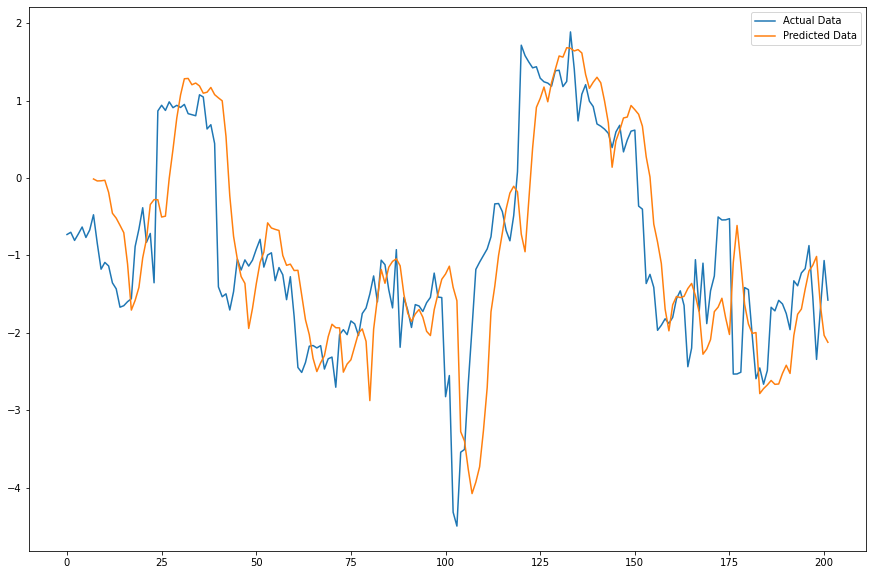

In [27]:
df["EMA"] = df["CLOSE"].ewm(span=60, adjust=False).mean()
df["EMA2"] = df["Predicted Testing Data"].ewm(span=60, adjust=False).mean()
ema_change = []
predicted_change = []
for i in range(3800, len(df)):
    ema_change.append(df["EMA"][i]-df["EMA"][i-1])
    predicted_change.append(df["EMA2"][i]-df["EMA2"][i-1])

plt.figure(figsize=(15,10))
plt.plot(ema_change, label="Actual Data")
plt.plot(predicted_change, label="Predicted Data")
plt.legend()
plt.show()